In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

import copy
%matplotlib inline
import matplotlib.pyplot as plt
%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import numpy as np
from utils_plot import show_sws_weights
import seaborn as sns

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
class plot_data():
    def __init__(self, init_model, gmp="", retrain=False, train=False, test=False, val=False, loss_type='CE'):
        self.layers =  [x.replace(".weight", "") for x in init_model.state_dict().keys() if "weight" in x]
        self.layer_init_weights = {}
        for l in self.layers:
            self.layer_init_weights[l] = np.concatenate([ init_model.state_dict()[l + ".weight"].clone().view(-1).cpu().numpy() , init_model.state_dict()[l + ".bias"].clone().view(-1).cpu().numpy() ])
        self.layer_weights = {}
        
        if (test):
            self.test_data_full = Variable(test_data(fetch='data')).cuda()
            self.test_labels_full = Variable(test_data(fetch='labels')).cuda()
            
        if (val):
            self.val_data_full = Variable(train_data(fetch='data')[50000:60000]).cuda()
            self.val_labels_full = Variable(train_data(fetch='labels')[50000:60000]).cuda()
            
        if (train and val):
            self.train_data_full = Variable(train_data(fetch='data')[40000:50000]).cuda()
            self.train_labels_full = Variable(train_data(fetch='labels')[40000:50000]).cuda()
            
        if (train and not val):
            self.train_data_full = Variable(train_data(fetch='data')).cuda()
            self.train_labels_full = Variable(train_data(fetch='labels')).cuda()
            
        self.retrain = retrain
        self.loss_type = loss_type
            
        #accuracy and lost tracking flags
        self.test = test
        self.val = val
        self.train = train
        
        #accuracy and loss history
        self.epochs = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.val_accuracy = []
        self.train_loss = []
        self.test_loss = []
        self.val_loss = []
        self.complexity_loss = []
        
        #gmp tracking
        if (retrain):
            self.gmp_stddev = np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy())
            self.gmp_means = gmp.means.data.clone().cpu().numpy()
            self.gmp_mixprop = gmp.rhos.exp().data.clone().cpu().numpy()
        
    def data_epoch(self, epoch, model, gmp=""):
        self.epochs.append(epoch)
        
        #Updated Model Weights
        for l in self.layers:
            self.layer_weights[l] = np.concatenate([ model.state_dict()[l + ".weight"].clone().view(-1).cpu().numpy() , model.state_dict()[l + ".bias"].clone().view(-1).cpu().numpy() ])
        
        if (self.test):
            test_acc = test_accuracy(self.test_data_full, self.test_labels_full, model, loss_type = self.loss_type)
            self.test_accuracy.append(test_acc[0])
            self.test_loss.append(test_acc[1])
        if (self.train):
            train_acc = test_accuracy(self.train_data_full, self.train_labels_full, model, loss_type = self.loss_type)
            self.train_accuracy.append(train_acc[0])
            self.train_loss.append(train_acc[1])
        if (self.val):
            val_acc = test_accuracy(self.val_data_full, self.val_labels_full, model, loss_type = self.loss_type)
            self.val_accuracy.append(val_acc[0])
            self.val_loss.append(val_acc[1])
            
        if (self.retrain):
            self.complexity_loss.append(float(gmp.call()[0]))
            self.gmp_stddev = np.vstack((self.gmp_stddev,  np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy()) ))
            self.gmp_means = np.vstack((self.gmp_means, gmp.means.data.clone().cpu().numpy() ))
            self.gmp_mixprop = np.vstack((self.gmp_mixprop, gmp.rhos.exp().data.clone().cpu().numpy() ))
            
    def get_weights(self, source='in'):
        if 'in':
            return np.concatenate([self.layer_weights[x] for x in self.layer_weights])
        else:
            np.concatenate([self.layer_weights[x] for x in self.layer_weights])

In [4]:
#python train_model.py --model SWSModel --epochs 100 --data search
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable

import model_archs
from utils_model import test_accuracy, train_epoch, train_epoch_l2
from utils_misc import trueAfterN, model_load_dir
from utils_plot import print_dims
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size

from tensorboardX import SummaryWriter
writeTensorboard = True
if(writeTensorboard):
    writer = SummaryWriter('tensorboard/')

def train_model(model_name, data_size, training_epochs, w=0):
    if(data_size == 'search'):
        train_dataset = search_train_data()
    if(data_size == 'full'):
        train_dataset = train_data()
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    if model_name == "SWSModel":
        model = model_archs.SWSModel().cuda()
    else:
        model = model_archs.LeNet_300_100().cuda()

    print ("Model Name: {} Epochs: {} Data: {}".format(model.name, training_epochs, data_size))
    print_dims(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay = 0)
    
    train_stats = plot_data(model, retrain=False, train=True, val=False, test=True)
    train_stats.data_epoch(0, model)
    
    for epoch in range(training_epochs):
        model, loss = train_epoch_l2(model, optimizer, criterion, train_loader, w=w)
        train_stats.data_epoch(epoch+1, model)
        writer.add_histogram('pretrain/l2', train_stats.get_weights('out'), epoch+1, bins='doane')
        
        if (trueAfterN(epoch, 10)):
            print('Epoch: {}. Test Accuracy: {:.2f} Loss: {}'.format(epoch+1, train_stats.test_accuracy[-1], float(loss) ))

    return model, train_stats

In [5]:
model, train_stats = train_model('LeNet', 'full', 100)

Model Name: LeNet_300_100 Epochs: 100 Data: full
300x784 + 300
100x300 + 100
10x100 + 10
Epoch: 10. Test Accuracy: 96.73 Loss: 0.0
Epoch: 20. Test Accuracy: 97.77 Loss: 0.0
Epoch: 30. Test Accuracy: 97.66 Loss: 0.0
Epoch: 40. Test Accuracy: 98.09 Loss: 0.0
Epoch: 50. Test Accuracy: 97.97 Loss: 0.0
Epoch: 60. Test Accuracy: 98.15 Loss: 0.0
Epoch: 70. Test Accuracy: 97.79 Loss: 0.0
Epoch: 80. Test Accuracy: 98.04 Loss: 0.0
Epoch: 90. Test Accuracy: 97.98 Loss: 0.0
Epoch: 100. Test Accuracy: 97.80 Loss: 0.0


In [6]:
model_l2, train_stats_l2 = train_model('LeNet', 'full', 100, w=0.0005)

Model Name: LeNet_300_100 Epochs: 100 Data: full
300x784 + 300
100x300 + 100
10x100 + 10
Epoch: 10. Test Accuracy: 96.93 Loss: 0.0
Epoch: 20. Test Accuracy: 97.70 Loss: 0.0
Epoch: 30. Test Accuracy: 97.81 Loss: 0.0
Epoch: 40. Test Accuracy: 97.81 Loss: 0.0
Epoch: 50. Test Accuracy: 97.75 Loss: 0.0
Epoch: 60. Test Accuracy: 97.68 Loss: 0.0
Epoch: 70. Test Accuracy: 97.97 Loss: 0.0
Epoch: 80. Test Accuracy: 97.89 Loss: 0.0
Epoch: 90. Test Accuracy: 98.23 Loss: 0.0
Epoch: 100. Test Accuracy: 97.74 Loss: 0.0


(-0.3, 0.3)

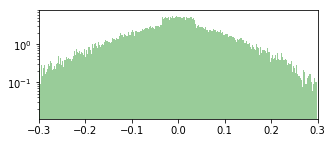

In [38]:
plt.figure(figsize=[5,2])
sns.distplot(train_stats.layer_weights['fc1'], kde=False, color="g",bins=5000,norm_hist=True, hist_kws={'log':True})
plt.xlim([-0.3,0.3])

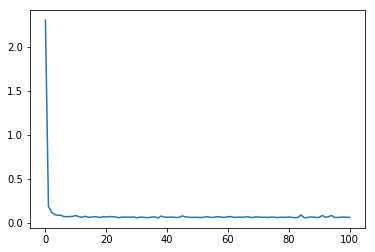

In [109]:
plt.plot(train_stats.epochs, train_stats.test_loss)

In [49]:
from utils_model import model_prune
pruner = model_prune(model.state_dict())
model_c = model_archs.LeNet_300_100().cuda()
perc_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : [],} 

test_data_full =  Variable(test_data(fetch = "data")).cuda()
test_labels_full =  Variable(test_data(fetch = "labels")).cuda()
train_data_full =  Variable(train_data(fetch = "data")).cuda()
train_labels_full =  Variable(train_data(fetch = "labels")).cuda()

for lim in range(0,101):
    model_c.load_state_dict(pruner.percentile_prune(lim))

    test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
    train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
    perc_res['train ce'].append(train_acc[1])
    perc_res['test ce'].append(test_acc[1])
    perc_res['train acc'].append(train_acc[0])
    perc_res['test acc'].append(test_acc[0])
    perc_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)

In [55]:
perc_res['train ce']

[0.11796770989894867,
 0.11797995865345001,
 0.11795367300510406,
 0.11795684695243835,
 0.11797734349966049,
 0.11785898357629776,
 0.11764560639858246,
 0.11770465224981308,
 0.1176934763789177,
 0.11753717809915543,
 0.11724656075239182,
 0.1173209697008133,
 0.11728695780038834,
 0.1170133426785469,
 0.11710570752620697,
 0.11735354363918304,
 0.11754236370325089,
 0.11751579493284225,
 0.11773689091205597,
 0.11782676726579666,
 0.11716189980506897,
 0.11727439612150192,
 0.11751899868249893,
 0.1175469234585762,
 0.11742830276489258,
 0.11763625591993332,
 0.11773232370615005,
 0.1179601401090622,
 0.11720585823059082,
 0.11720096319913864,
 0.11686406284570694,
 0.11637923121452332,
 0.116874098777771,
 0.11720870435237885,
 0.11636202782392502,
 0.11653462052345276,
 0.11600787937641144,
 0.11626944690942764,
 0.11510849744081497,
 0.1143960952758789,
 0.11261390149593353,
 0.11282428354024887,
 0.1122516393661499,
 0.11361599713563919,
 0.11427045613527298,
 0.1116622611880302

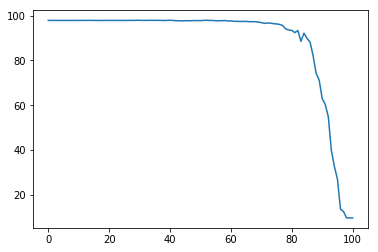

In [58]:
plt.plot(perc_res['test acc'])

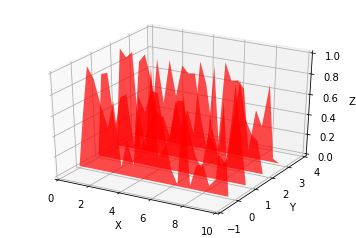

In [53]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')


def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = np.arange(0, 10, 0.4)
verts = []
zs = [0.0, 1.0, 2.0, 3.0]
for z in zs:
    ys = np.random.rand(len(xs))
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))

poly = PolyCollection(verts, facecolors=[cc('r'), cc('r'), cc('r'),
                                         cc('r')])
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')

ax.set_xlabel('X')
ax.set_xlim3d(0, 10)
ax.set_ylabel('Y')
ax.set_ylim3d(-1, 4)
ax.set_zlabel('Z')
ax.set_zlim3d(0, 1)

plt.show()